In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from numba.typed import Dict
from numba.core import types

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.models.aln import ALNModel

from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, oc_aln, cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

def plot_control(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0].plot(time_array, s[n,0,:], color="red")
        ax[1].plot(time_array, c[n,0,:], color="red")
        ax[1].plot(time_array, c[n,1,:], color="blue")

    ax[0].set_xlim(0, dur)

    ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [3]:
## WC Model

coords_WC = [[1., 1.], [3., 1.]]

data_WC = dict()
data_WC["coordinates"] = [coords_WC[0], coords_WC[1]]
data_WC["control"] = [None , None]
data_WC["state"] = [None , None]
data_WC["init_state"] = [None , None]
data_WC["energy_input"] = np.zeros((2))

N = 1
model = WCModel()
dt = model.params['dt']

In [4]:
model = WCModel()
testd = 1e4
model.params.duration = testd
model.params.dt = dt

for ci in range(2):
    model.params.exc_ext_baseline = data_WC["coordinates"][ci][0]
    model.params.inh_ext_baseline = data_WC["coordinates"][ci][1]

    model.run()

    einit = np.zeros((N, 1))
    iinit = np.zeros((N, 1))
    for n in range(N):
        einit[n,:] = model.exc[n,-1]
        iinit[n,:] = model.inh[n,-1]

    data_WC["init_state"][ci] = [einit, iinit]

In [19]:
# read data, if existing
with open(os.path.join(os.getcwd(), '3_1_WC.pickle'), 'rb') as f:
    res_read = pickle.load(f)

data_WC = res_read.copy()

In [5]:
controlmat = np.zeros((N,4))
controlmat[0,0] = 1

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

duration = 400.
target_period = 30

int0 = 500
int1 = 3500

model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

max_cntrl = 5
pr = np.arange(0,101,10)

In [18]:
w_f_osc = 8. * 1e4

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -5.2813666742759925e-30
Final cost : -304.97508051479605
Compute control for a deterministic system
Cost in iteration 0: -304.97508051479605
Cost in iteration 10: -340.7662791234727
Cost in iteration 20: -1311.6882917676514
Final cost : -1311.6882917676514
Compute control for a deterministic system
Cost in iteration 0: -1311.6882917676514
Cost in iteration 10: -1341.8841546560159
Cost in iteration 20: -1375.7653509709264
Final cost : -1375.7653509709264
Compute control for a deterministic system
Cost in iteration 0: -1375.7653509709264
Cost in iteration 10: -1375.9808191516174
Cost in iteration 20: -1375.996189250194
Final cost : -1375.996189250194
Compute control for a deterministic system
Cost in iteration 0: -1375.996189250194
Cost in iteration 10: -1375.9969597537292
Cost in iteration 20: -1375.997050735644
Final cost : -1375.997050735644
Compute control for a deterministi

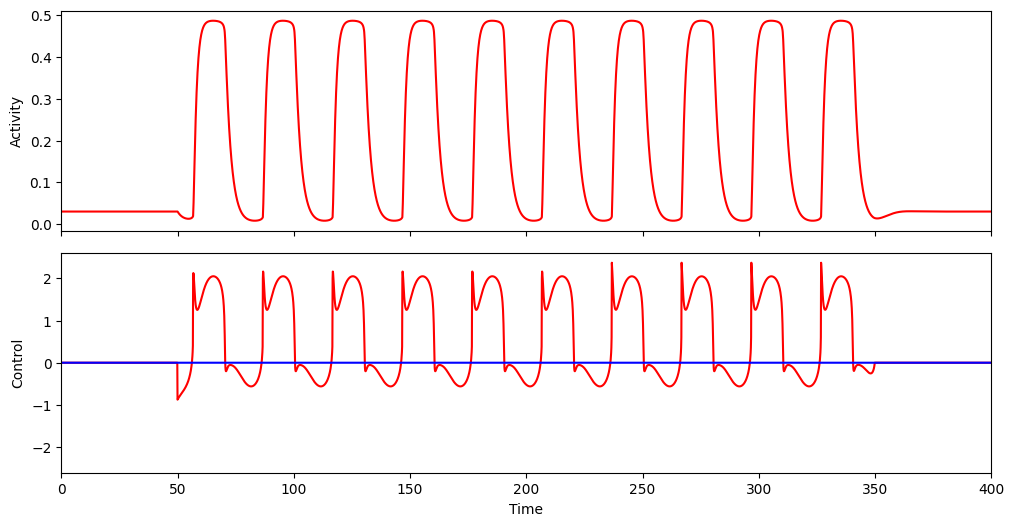

In [6]:
ci = 0  # down to osc task

model = WCModel()
model.params.exc_init = data_WC["init_state"][ci][0]
model.params.inh_init = data_WC["init_state"][ci][1]

model.params["exc_ext_baseline"] =  data_WC["coordinates"][ci][0]
model.params["inh_ext_baseline"] =  data_WC["coordinates"][ci][1]
model.params.duration = duration

model.run()

model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = w_f_osc

model_controlled.maximum_control_strength = max_cntrl

# find initial signal
model_controlled.zero_step_encountered = False
model_controlled.step = 10**(18.)
model_controlled.optimize(1)

for l in range(1):
    for k in np.arange(-6., 7., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(20)

data_WC["control"][ci] = model_controlled.control.copy()
data_WC["state"][ci] = model_controlled.get_xs()

data_WC["energy_input"][ci] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1375.997071751971
Converged in iteration 1 with cost -1375.997071751971
Final cost : -1375.997071751971
Compute control for a deterministic system
Cost in iteration 0: -1375.997071751971
Converged in iteration 2 with cost -1375.997071751971
Final cost : -1375.997071751971
Compute control for a deterministic system
Cost in iteration 0: -1375.997071751971
Converged in iteration 2 with cost -1375.997071751971
Final cost : -1375.997071751971
Compute control for a deterministic system
Cost in iteration 0: -1375.997071751971
Converged in iteration 1 with cost -1375.997071751971
Final cost : -1375.997071751971
Compute control for a deterministic system
Cost in iteration 0: -1375.997071751971
Converged in iteration 1 with cost -1375.997071751971
Final cost : -1375.997071751971
Compute control for a deterministic system
Cost in iteration 0: -1375.997071751971
Converged in iteration 1 

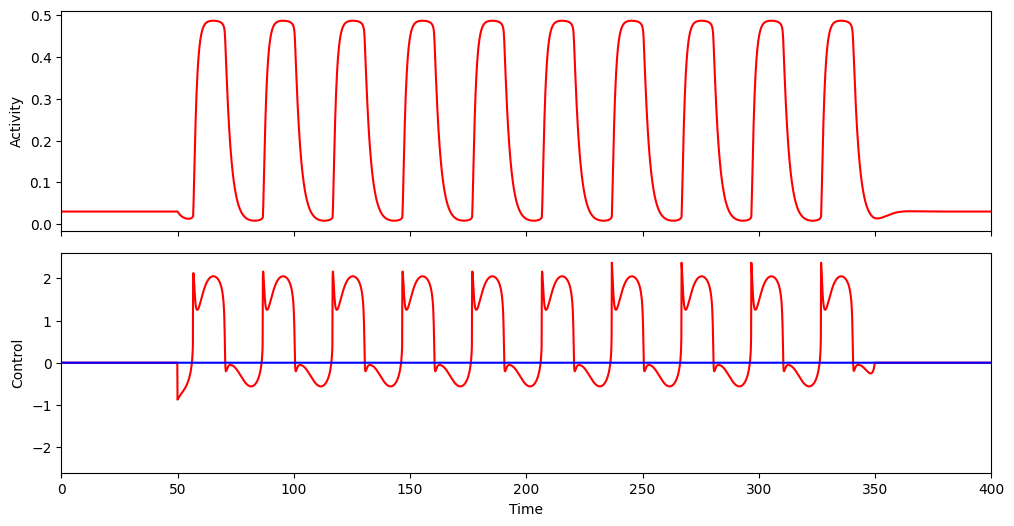

In [20]:
# rerun until convergence
ci = 0  # down to osc task

model = WCModel()
model.params.exc_init = data_WC["init_state"][ci][0]
model.params.inh_init = data_WC["init_state"][ci][1]

model.params["exc_ext_baseline"] =  data_WC["coordinates"][ci][0]
model.params["inh_ext_baseline"] =  data_WC["coordinates"][ci][1]
model.params.duration = duration

model.run()

model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = w_f_osc

model_controlled.maximum_control_strength = max_cntrl

model_controlled.control = data_WC["control"][ci].copy()
model_controlled.update_input()

model_controlled.optimize(1)

for j in range(5):

    model_controlled.grad_method = 0

    for l in range(1):
        for k in np.arange(-6., 7., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(20)
    
    model_controlled.grad_method = 1

    for l in range(1):
        for k in np.arange(-6., 7., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(10)

data_WC["control"][ci] = model_controlled.control.copy()
data_WC["state"][ci] = model_controlled.get_xs()

data_WC["energy_input"][ci] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [22]:
# save result into pickle file
with open(os.path.join(os.getcwd(), '3_1_WC.pickle'), 'wb') as f:
    pickle.dump(data_WC, f)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -3.900161843980583e-28
Final cost : -741.318636721211
Compute control for a deterministic system
Cost in iteration 0: -741.318636721211
Cost in iteration 10: -746.8094875760682
Cost in iteration 20: -1317.4004548722924
Final cost : -1317.4004548722924
Compute control for a deterministic system
Cost in iteration 0: -1317.4004548722924
Cost in iteration 10: -1334.8314568956084
Cost in iteration 20: -1349.2646755899389
Final cost : -1349.2646755899389
Compute control for a deterministic system
Cost in iteration 0: -1349.2646755899389
Cost in iteration 10: -1349.7222472042608
Cost in iteration 20: -1350.098405674285
Final cost : -1350.098405674285
Compute control for a deterministic system
Cost in iteration 0: -1350.098405674285
Cost in iteration 10: -1350.4527533332382
Cost in iteration 20: -1350.9542191905812
Final cost : -1350.9542191905812
Compute control for a deterministic s

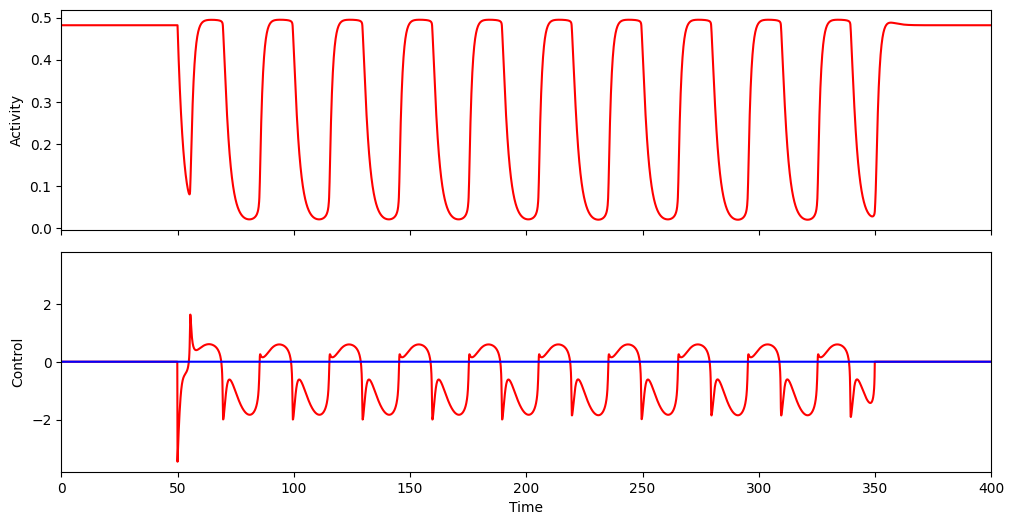

In [17]:
ci = 1  # up to osc task

model = WCModel()
model.params.exc_init = data_WC["init_state"][ci][0]
model.params.inh_init = data_WC["init_state"][ci][1]

model.params["exc_ext_baseline"] =  data_WC["coordinates"][ci][0]
model.params["inh_ext_baseline"] =  data_WC["coordinates"][ci][1]
model.params.duration = duration

model.run()

model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = w_f_osc

model_controlled.maximum_control_strength = max_cntrl

# find initial signal
model_controlled.zero_step_encountered = False
model_controlled.step = 10**(15.)
model_controlled.optimize(1)

for l in range(1):
    for k in np.arange(-6., 7., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(20)

data_WC["control"][ci] = model_controlled.control.copy()
data_WC["state"][ci] = model_controlled.get_xs()

data_WC["energy_input"][ci] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1371.0020487554923
Final cost : -1371.1325316745808
Compute control for a deterministic system
Cost in iteration 0: -1371.1325316745808
Cost in iteration 10: -1371.1385171194283
Cost in iteration 20: -1372.594697711087
Final cost : -1372.594697711087
Compute control for a deterministic system
Cost in iteration 0: -1372.594697711087
Cost in iteration 10: -1372.7709315136199
Cost in iteration 20: -1375.303759585555
Final cost : -1375.303759585555
Compute control for a deterministic system
Cost in iteration 0: -1375.303759585555
Cost in iteration 10: -1377.5052692174218
Cost in iteration 20: -1380.0875474177615
Final cost : -1380.0875474177615
Compute control for a deterministic system
Cost in iteration 0: -1380.0875474177615
Cost in iteration 10: -1382.6988697448166
Cost in iteration 20: -1386.2191486294253
Final cost : -1386.2191486294253
Compute control for a deterministic sy

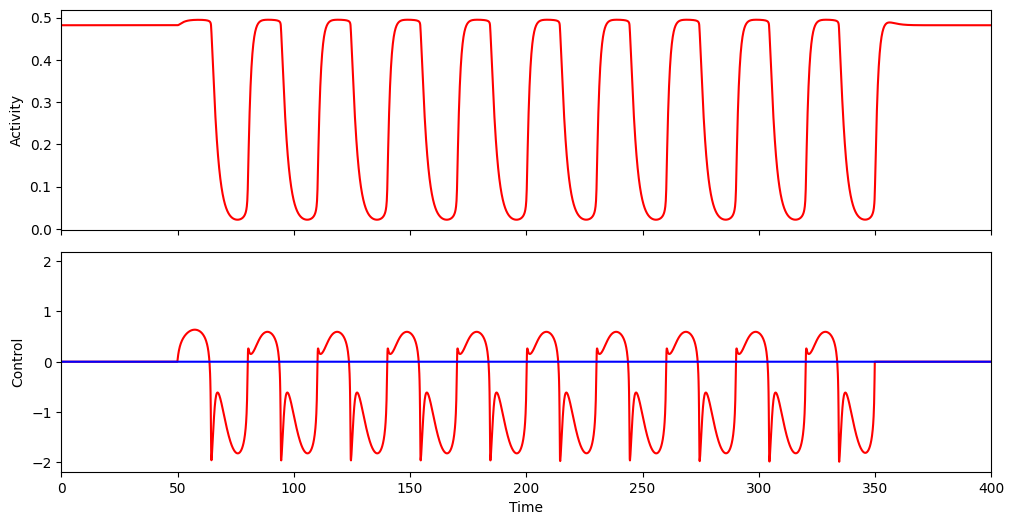

In [21]:
# rerun until convergence
ci = 1  # up to osc task

model = WCModel()
model.params.exc_init = data_WC["init_state"][ci][0]
model.params.inh_init = data_WC["init_state"][ci][1]

model.params["exc_ext_baseline"] =  data_WC["coordinates"][ci][0]
model.params["inh_ext_baseline"] =  data_WC["coordinates"][ci][1]
model.params.duration = duration

model.run()

model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = w_f_osc

model_controlled.maximum_control_strength = max_cntrl

model_controlled.control = data_WC["control"][ci].copy()
model_controlled.update_input()

model_controlled.optimize(1)

for j in range(1):

    model_controlled.grad_method = 0

    for l in range(1):
        for k in np.arange(-6., 7., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(20)
    
    model_controlled.grad_method = 1

    for l in range(1):
        for k in np.arange(-6., 7., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(10)

data_WC["control"][ci] = model_controlled.control.copy()
data_WC["state"][ci] = model_controlled.get_xs()

data_WC["energy_input"][ci] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [6]:
### EIF model

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state

# This function sets the initial state of a model to specific values
def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

# This function reads the complete state of the EIF model
def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state



coords_EIF = [[1., 1.], [2.2, 1.]]

data_EIF = dict()
data_EIF["coordinates"] = [coords_EIF[0], coords_EIF[1]]
data_EIF["control"] = [None , None]
data_EIF["state"] = [None , None]
data_EIF["init_state"] = [None , None]
data_EIF["energy_input"] = np.zeros((2))

N = 1
model = ALNModel()
dt = model.params['dt']

In [ ]:
# read data, if existing
with open(os.path.join(os.getcwd(), '3_1_EIF.pickle'), 'rb') as f:
    res_read = pickle.load(f)

data_EIF = res_read.copy()

In [7]:
model = ALNModel()
testd = 1e4
model.params.duration = testd
model.params.dt = dt

for ci in range(2):
    model.params.mue_ext_mean = data_EIF["coordinates"][ci][0]
    model.params.mui_ext_mean = data_EIF["coordinates"][ci][1]

    model.run()

    data_EIF["init_state"][ci] = getfinalstate(model)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 76.23168253589905
Cost in iteration 10: 75.96384022106172
Cost in iteration 20: 32.36459157258767
Final cost : 32.36459157258767
Compute control for a deterministic system
Cost in iteration 0: 32.36459157258767
Cost in iteration 10: 20.432480428081846
Cost in iteration 20: -0.2436574700269034
Final cost : -0.2436574700269034
Compute control for a deterministic system
Cost in iteration 0: -0.2436574700269034
Cost in iteration 10: -2.5260118771219595
Cost in iteration 20: -2.822269413379729
Final cost : -2.822269413379729
Compute control for a deterministic system
Cost in iteration 0: -2.822269413379729
Converged in iteration 3 with cost -2.841347840377921
Final cost : -2.841347840377921
Compute control for a deterministic system
Cost in iteration 0: -2.841347840377921
Converged in iteration 1 with cost -2.841347840377921
Final cost : -2.841347840377921
Compute control for a det

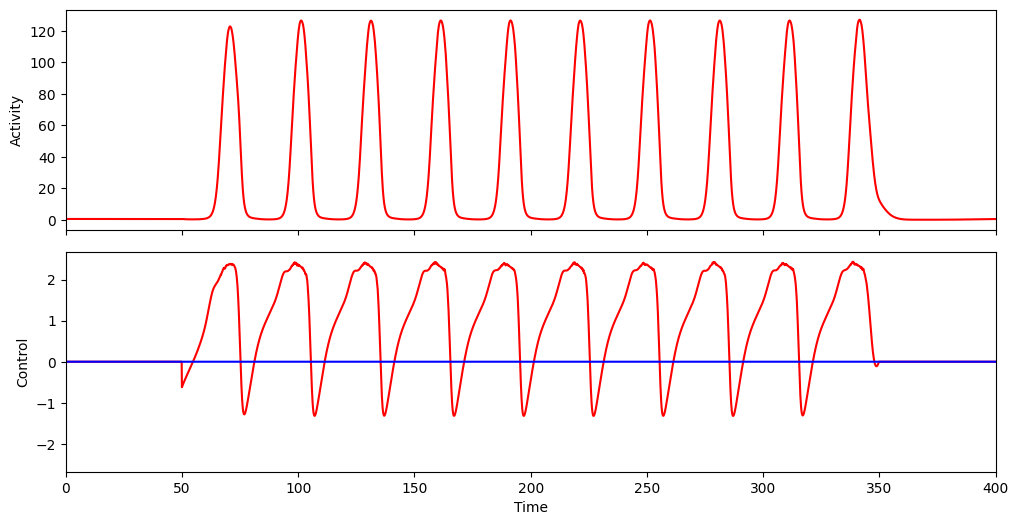

In [8]:
ci = 0  # down to osc task
w_f_osc_eif = 0.555

model = ALNModel()
setinitstate(model, data_EIF["init_state"][ci])
model.params["mue_ext_mean"] =  data_EIF["coordinates"][ci][0]
model.params["mui_ext_mean"] =  data_EIF["coordinates"][ci][1]
model.params.duration = duration

model.run()

model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = w_f_osc_eif

model_controlled.maximum_control_strength = max_cntrl

# initialize with oscillatory control signal
init_osc = 0.8 * (1. - np.cos(2.*np.pi*np.arange(0,300, dt)/target_period))
model_controlled.control[0,0,int0:int1] = init_osc
model_controlled.update_input()

for l in range(1):
    for k in np.arange(-6., 7., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(20)

data_EIF["control"][ci] = model_controlled.control.copy()
data_EIF["state"][ci] = model_controlled.get_xs()

data_EIF["energy_input"][ci] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -2.841347840377921
Converged in iteration 1 with cost -2.841347840377921
Final cost : -2.841347840377921
Compute control for a deterministic system
Cost in iteration 0: -2.841347840377921
Converged in iteration 1 with cost -2.841347840377921
Final cost : -2.841347840377921
Compute control for a deterministic system
Cost in iteration 0: -2.841347840377921
Converged in iteration 1 with cost -2.841347840377921
Final cost : -2.841347840377921
Compute control for a deterministic system
Cost in iteration 0: -2.841347840377921
Converged in iteration 1 with cost -2.841347840377921
Final cost : -2.841347840377921
Compute control for a deterministic system
Cost in iteration 0: -2.841347840377921
Converged in iteration 1 with cost -2.841347840377921
Final cost : -2.841347840377921
Compute control for a deterministic system
Cost in iteration 0: -2.841347840377921
Converged in iteration 1 

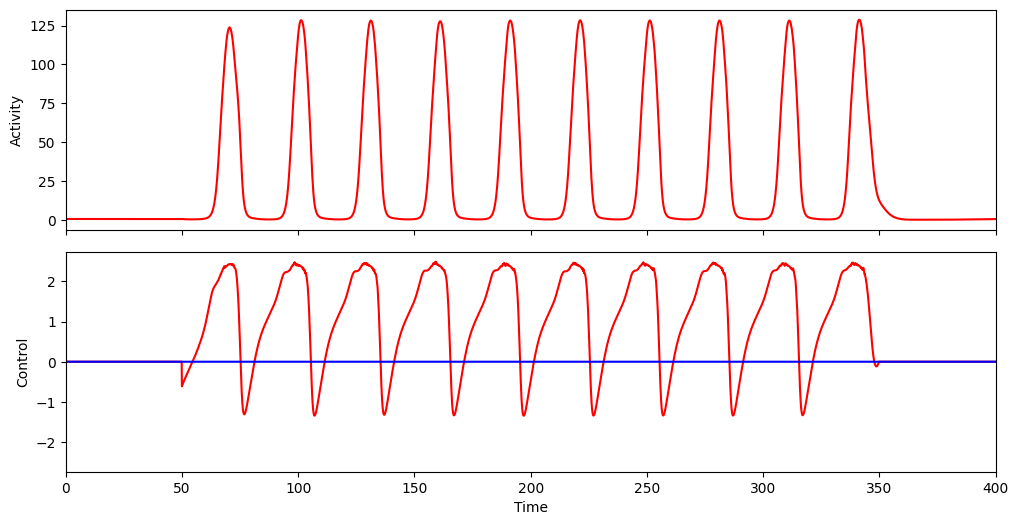

In [23]:
# rerun until convergence
ci = 0  # down to osc task

model = ALNModel()
setinitstate(model, data_EIF["init_state"][ci])
model.params["mue_ext_mean"] =  data_EIF["coordinates"][ci][0]
model.params["mui_ext_mean"] =  data_EIF["coordinates"][ci][1]
model.params.duration = duration

model.run()

model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = w_f_osc_eif

model_controlled.maximum_control_strength = max_cntrl

model_controlled.control = data_EIF["control"][ci].copy()
model_controlled.update_input()

for j in range(1):
    model_controlled.grad_method = 0

    for l in range(1):
        for k in np.arange(-6., 7., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(20)
    
    model_controlled.grad_method = 1

    for l in range(1):
        for k in np.arange(-6., 7., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(10)

data_EIF["control"][ci] = model_controlled.control.copy()
data_EIF["state"][ci] = model_controlled.get_xs()

data_EIF["energy_input"][ci] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [25]:
# save result into pickle file
with open(os.path.join(os.getcwd(), '3_1_EIF.pickle'), 'wb') as f:
    pickle.dump(data_EIF, f)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -2.791143487464783e-29
Final cost : -0.013169559282872367
Compute control for a deterministic system
Cost in iteration 0: -0.013169559282872367
Final cost : -0.013169895747023902
Compute control for a deterministic system
Cost in iteration 0: -0.013169895747023902
Final cost : -0.013203558661773565
Compute control for a deterministic system
Cost in iteration 0: -0.013203558661773565
Final cost : -0.016740369085054344
Compute control for a deterministic system
Cost in iteration 0: -0.016740369085054344
Final cost : -13.414160371793004
Compute control for a deterministic system
Cost in iteration 0: -13.414160371793004
Final cost : -142.92206722793955
Compute control for a deterministic system
Cost in iteration 0: -142.92206722793955
Converged in iteration 2 with cost -223.08312955063423
Final cost : -223.08312955063423
Compute control for a deterministic system
Cost in iteration

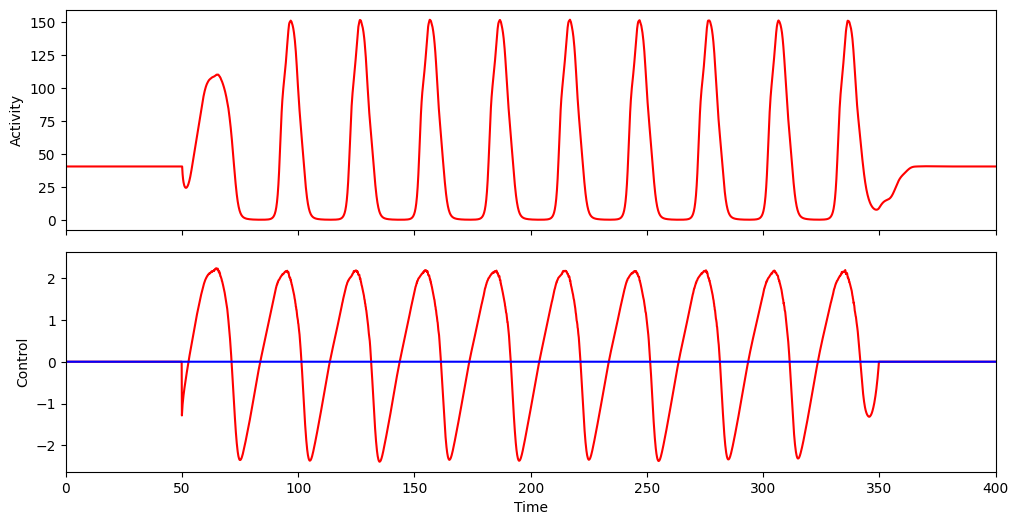

In [14]:
ci = 1  # up to osc task

model = ALNModel()
setinitstate(model, data_EIF["init_state"][ci])
model.params["mue_ext_mean"] =  data_EIF["coordinates"][ci][0]
model.params["mui_ext_mean"] =  data_EIF["coordinates"][ci][1]
model.params.duration = duration

model.run()

model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = w_f_osc_eif

model_controlled.maximum_control_strength = max_cntrl

# find initial signal
model_controlled.zero_step_encountered = False
model_controlled.step = 10**(13.)
model_controlled.optimize(1)

for l in range(1):
    for k in np.arange(-6., 7., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(20)

data_EIF["control"][ci] = model_controlled.control.copy()
data_EIF["state"][ci] = model_controlled.get_xs()

data_EIF["energy_input"][ci] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -225.73927890353514
Converged in iteration 1 with cost -225.73927890353514
Final cost : -225.73927890353514
Compute control for a deterministic system
Cost in iteration 0: -225.73927890353514
Converged in iteration 1 with cost -225.73927890353514
Final cost : -225.73927890353514
Compute control for a deterministic system
Cost in iteration 0: -225.73927890353514
Converged in iteration 1 with cost -225.73927890353514
Final cost : -225.73927890353514
Compute control for a deterministic system
Cost in iteration 0: -225.73927890353514
Converged in iteration 1 with cost -225.73927890353514
Final cost : -225.73927890353514
Compute control for a deterministic system
Cost in iteration 0: -225.73927890353514
Converged in iteration 1 with cost -225.73927890353514
Final cost : -225.73927890353514
Compute control for a deterministic system
Cost in iteration 0: -225.73927890353514
Converged

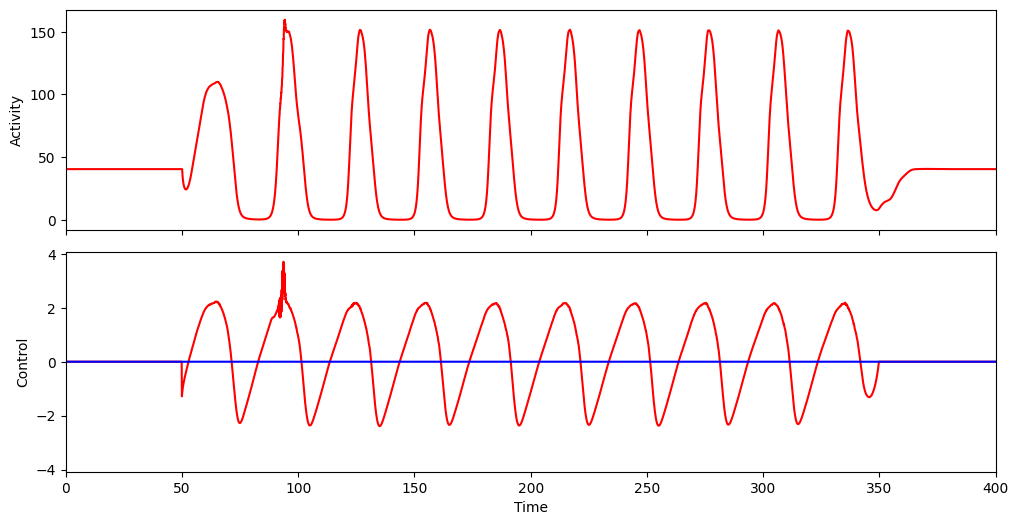

In [24]:
# rerun until convergence
ci = 1  # up to osc task

model = ALNModel()
setinitstate(model, data_EIF["init_state"][ci])
model.params["mue_ext_mean"] =  data_EIF["coordinates"][ci][0]
model.params["mui_ext_mean"] =  data_EIF["coordinates"][ci][1]
model.params.duration = duration

model.run()

model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = w_f_osc_eif

model_controlled.maximum_control_strength = max_cntrl

model_controlled.control = data_EIF["control"][ci].copy()
model_controlled.update_input()

for j in range(1):
    model_controlled.grad_method = 0

    for l in range(1):
        for k in np.arange(-6., 7., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(20)
    
    model_controlled.grad_method = 1

    for l in range(1):
        for k in np.arange(-6., 7., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(10)

data_EIF["control"][ci] = model_controlled.control.copy()
data_EIF["state"][ci] = model_controlled.get_xs()

data_EIF["energy_input"][ci] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)